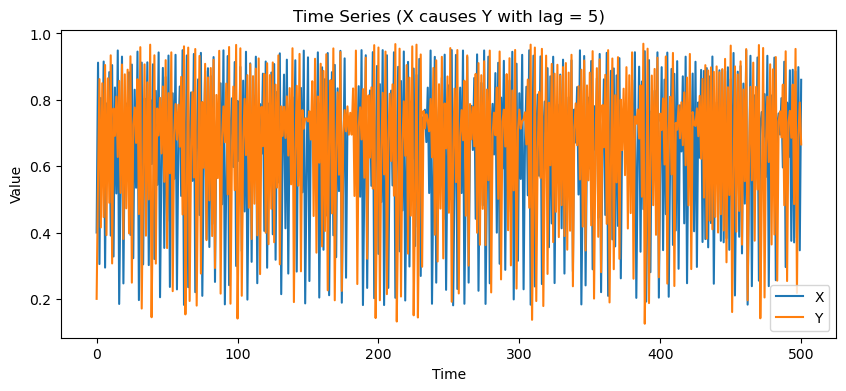

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEDM import CCM
import plotly.graph_objects as go

# PARAMETERS for the new system
r_x = 3.8        # logistic parameter for X
r_y = 3.5        # logistic parameter for Y
B_yx = 0.1       # effect of X on Y (with lag)
LAG = 5          # the explicit lag from X to Y
t_total = 500    # number of time steps

# Initial conditions
X0 = 0.4
Y0 = 0.2

# Generate time series
X = [X0]
Y = [Y0]

for t in range(t_total):
    # Evolve X with a logistic map
    X_new = r_x * X[-1] * (1 - X[-1])
    X.append(X_new)
    # For Y, use its own logistic dynamics plus a forcing from X delayed by LAG
    if t < LAG:
        # For early times, before lag is available, evolve Y on its own.
        Y_new = r_y * Y[-1] * (1 - Y[-1])
    else:
        # For t >= LAG, include the influence from X[t - LAG]
        Y_new = r_y * Y[-1] * (1 - Y[-1]) + B_yx * X[t - LAG]
    Y.append(Y_new)

time = list(range(t_total + 1))

# Plot the time series for X and Y
plt.figure(figsize=(10, 4))
plt.plot(time, X, label="X", color='tab:blue')
plt.plot(time, Y, label="Y", color='tab:orange')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Time Series (X causes Y with lag = {LAG})")
plt.legend()
plt.show()


In [83]:

# Build a dataframe for pyEDM
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})


Tps = range(-10, 11)  # scanning Tp from -10 to 10
forward_max_rhos = []  # for X -> Y
reverse_max_rhos = []  # for Y -> X

# For each Tp, run CCM
for Tp in Tps:
    ccm_out = CCM(
        dataFrame   = df,
        E           = 2,
        tau         = 1,
        columns     = 'X',    # use X as the library (predictor)
        target      = 'Y',    # predict Y (target)
        libSizes    = '100 200 300 400',
        sample      = 100,
        random      = True,
        replacement = False,
        Tp          = Tp
    )

    forward_rho = ccm_out['X:Y'].max()  # X->Y (i.e. predicting Y from X)
    reverse_rho = ccm_out['Y:X'].max()  # Y->X (predicting X from Y)
    forward_max_rhos.append(forward_rho)
    reverse_max_rhos.append(reverse_rho)

# Plot the CCM skill vs. Tp using Plotly
fig = go.Figure()

# Plot for X -> Y
fig.add_trace(go.Scatter(
    x=list(Tps),
    y=forward_max_rhos,
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{Y}}\mid M_{{X}}$)"
))
# Plot for Y -> X
fig.add_trace(go.Scatter(
    x=list(Tps),
    y=reverse_max_rhos,
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{X}}\mid M_{{Y}}$)"
))

fig.update_layout(
    title="Max CCM Skill vs. Tp",
    xaxis_title="Tp (Time displacement)",
    yaxis_title="Max CCM Skill (rho)",
    width=900,
    height=400
)
fig.update_xaxes(tickmode='array', tickvals=list(Tps))
fig.show()


# Test on Vostok data

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# read the csv files and plot the data
df_AT = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\AT.csv")
df_CO2 = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\CO2.csv")
df_CH4 = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\CH4.csv")
df_inso = pd.read_csv(r"D:\VScode\van2015_repeat\VOSTOK_data\insolation.csv")

In [56]:
df_CO2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     399 non-null    int64  
 1   CO2     399 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB


In [70]:
time=df_AT['age']
X = df_AT['AT']
Y = df_CO2['CO2']

# Build a dataframe for pyEDM
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})


Tps = range(-10, 11)  # scanning Tp from -10 to 10
forward_max_rhos = []  # for X -> Y
reverse_max_rhos = []  # for Y -> X

# For each Tp, run CCM
for Tp in Tps:
    ccm_out = CCM(
        dataFrame   = df,
        E           = 4,
        tau         = 2,
        columns     = 'X',    # use X as the library (predictor)
        target      = 'Y',    # predict Y (target)
        libSizes    = '300',
        sample      = 100,
        random      = True,
        replacement = True,
        Tp          = Tp
    )

    forward_rho = ccm_out['X:Y'].max()  # X->Y (i.e. predicting Y from X)
    reverse_rho = ccm_out['Y:X'].max()  # Y->X (predicting X from Y)
    forward_max_rhos.append(forward_rho)
    reverse_max_rhos.append(reverse_rho)

# Plot the CCM skill vs. Tp using Plotly
fig = go.Figure()

# Plot for X -> Y
fig.add_trace(go.Scatter(
    x=list(Tps),
    y=forward_max_rhos,
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{Y}}\mid M_{{X}}$)"
))
# Plot for Y -> X
fig.add_trace(go.Scatter(
    x=list(Tps),
    y=reverse_max_rhos,
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{X}}\mid M_{{Y}}$)"
))

fig.update_layout(
    title="Max CCM Skill vs. Tp",
    xaxis_title="Tp (Time displacement)",
    yaxis_title="Max CCM Skill (rho)",
    width=900,
    height=400
)
fig.update_xaxes(tickmode='array', tickvals=list(Tps))
fig.show()


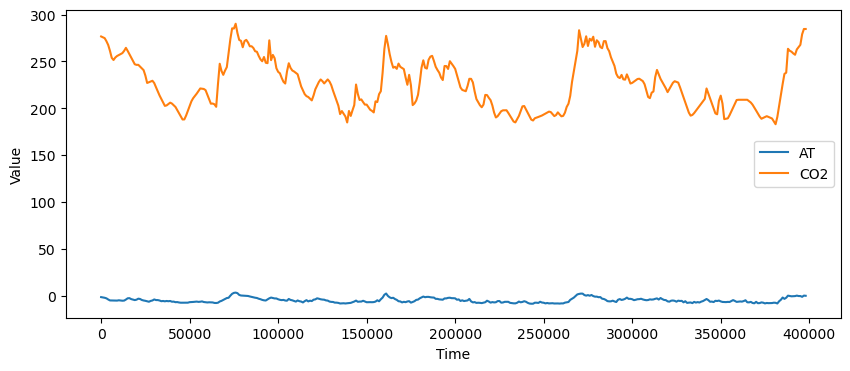

In [80]:
time=df_AT['age']
X = df_AT['AT']
Y = df_CO2['CO2']

# flip X AND Y
# X = X[::-1]
# Y = Y[::-1]
# time = time[::-1]


# plot X and Y
plt.figure(figsize=(10, 4)) 
plt.plot(time, X, label="AT", color='tab:blue')
plt.plot(time, Y, label="CO2", color='tab:orange')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# Build a dataframe for pyEDM
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})


Tps = range(-10, 11)  # scanning Tp from -10 to 10
forward_max_rhos = []  # for X -> Y
reverse_max_rhos = []  # for Y -> X

# For each Tp, run CCM
for Tp in Tps:
    ccm_out = CCM(
        dataFrame   = df,
        E           = 4,
        tau         = 2,
        columns     = 'X',    # use X as the library (predictor)
        target      = 'Y',    # predict Y (target)
        libSizes    = '300',
        sample      = 100,
        random      = True,
        replacement = False,
        Tp          = Tp
    )

    forward_rho = ccm_out['X:Y'].max()  # X->Y (i.e. predicting Y from X)
    reverse_rho = ccm_out['Y:X'].max()  # Y->X (predicting X from Y)
    forward_max_rhos.append(forward_rho)
    reverse_max_rhos.append(reverse_rho)

# Plot the CCM skill vs. Tp using Plotly
fig = go.Figure()

# Plot for X -> Y
fig.add_trace(go.Scatter(
    x=list(Tps),
    y=forward_max_rhos,
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{Y}}\mid M_{{X}}$)"
))
# Plot for Y -> X
fig.add_trace(go.Scatter(
    x=list(Tps),
    y=reverse_max_rhos,
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{X}}\mid M_{{Y}}$)"
))

fig.update_layout(
    title="Max CCM Skill vs. Tp",
    xaxis_title="Tp (Time displacement)",
    yaxis_title="Max CCM Skill (rho)",
    width=900,
    height=400
)
fig.update_xaxes(tickmode='array', tickvals=list(Tps))
fig.show()


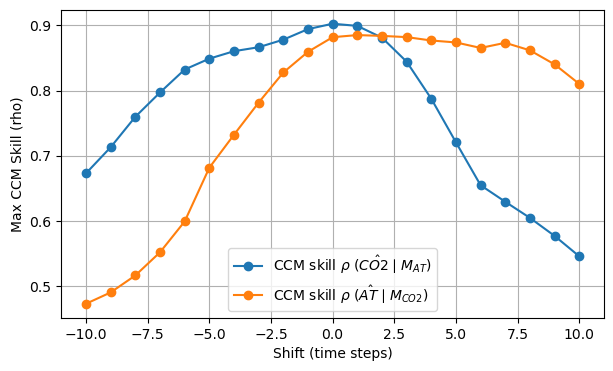

In [67]:
import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt



df_orig = pd.DataFrame({
    "Time": df_AT['age'],
    "AT": df_AT['AT'],
    "CO2": df_CO2['CO2'],
})


Tps = range(-10, 11)  
ccm_forward_rhos = []   # will record CCM skill for AT -> CO2
ccm_reverse_rhos = []   # will record CCM skill for CO2 -> AT

# Loop over each shift value.
for shift in Tps:
    df = df_orig.copy()
    df['AT'] = df_orig['AT'].shift(-shift)
    # Drop any rows with missing values (due to shifting)
    df = df.dropna().reset_index(drop=True)
    
    # Run CCM with Tp set to zero (no additional displacement)
    ccm_out = CCM(
        dataFrame   = df,
        E           = 4,               # embedding dimension (adjust as needed)
        tau         = 2,
        columns     = 'AT',            # predictor variable (shifted AT)
        target      = 'CO2',           # target variable
        libSizes    = '300',           # use a fixed library size for simplicity
        sample      = 100,
        random      = True,
        replacement = False,
        Tp          = 0                # no additional time displacement in CCM
    )
    
    # Record the maximum CCM skill (here we take the value at the last library size)
    max_forward_rho = ccm_out['AT:CO2'].iloc[-1]
    ccm_forward_rhos.append(max_forward_rho)
    
    # Also run the reverse CCM (CO2 -> AT) on the same shifted data.
    max_reverse_rho = ccm_out['CO2:AT'].iloc[-1]
    ccm_reverse_rhos.append(max_reverse_rho)

# Plot the maximum CCM skill versus the applied shift.
plt.figure(figsize=(7, 4))
plt.plot(list(Tps), ccm_forward_rhos, 'o-', color='tab:blue',
         label=fr"CCM skill $\rho$ ($\hat{{CO2}}\mid M_{{AT}}$)")
plt.plot(list(Tps), ccm_reverse_rhos, 'o-', color='tab:orange',
         label=fr"CCM skill $\rho$ ($\hat{{AT}}\mid M_{{CO2}}$)")
plt.xlabel("Shift (time steps)")
plt.ylabel("Max CCM Skill (rho)")
# plt.title("CCM Skill vs. Shift (AT shifted relative to CO₂)")
plt.legend()
plt.grid(True)
plt.show()


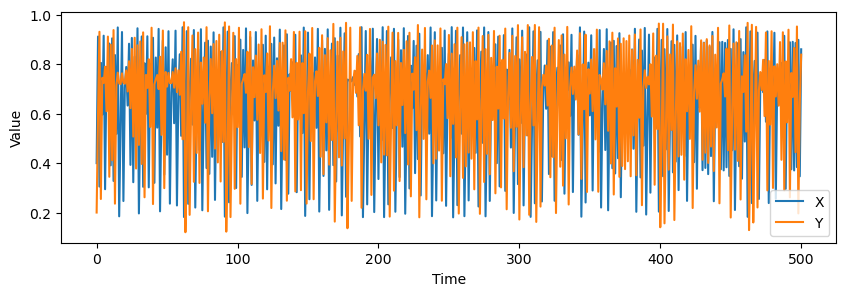

In [42]:
r_x = 3.8
r_y = 3.5
B_xy = 0.0 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 500 # time steps

def func_1(x, y, r, B):
    return r * x * (1 - x) + B * y

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)   

time=range(t+1)

# plot x and y
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
plt.plot(time, X, label='X')
plt.plot(time, Y, label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()


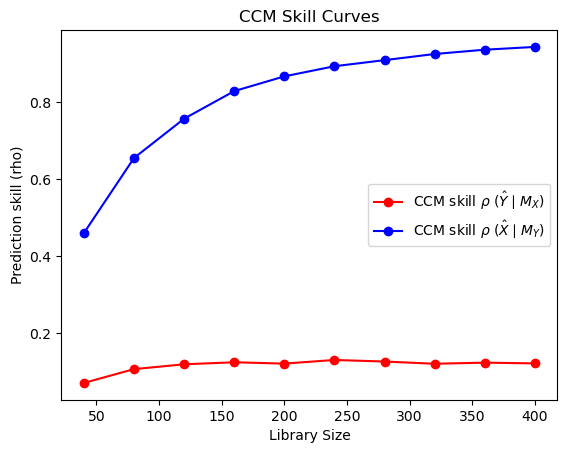

In [36]:
import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt
from scipy.stats import zscore

df = pd.DataFrame({
        "Time":        time,
        'X':   X,  # predictor
        'Y':  Y, # target
    })

ccm_out = CCM(
    dataFrame   = df,
    E           = 2,
    tau         = 1,
    columns     = 'X',   # predictor
    target      = 'Y',   # target
    libSizes    = '40 80 120 160 200 240 280 320 360 400',
    sample      = 40,
    random      = True,
    replacement = False,
    Tp          = 0
)

forward_key = 'X:Y'
reverse_key = 'Y:X'
column_name = 'X'
target_name = 'Y'   

fig, ax = plt.subplots()
ax.plot(ccm_out["LibSize"], ccm_out[forward_key],
        "ro-", label=fr"CCM skill $\rho$ ($\hat{{{target_name}}}\mid M_{{{column_name}}}$)")
ax.plot(ccm_out["LibSize"], ccm_out[reverse_key],
        "bo-", label=fr"CCM skill $\rho$ ($\hat{{{column_name}}}\mid M_{{{target_name}}}$)")
ax.set_xlabel("Library Size")
ax.set_ylabel("Prediction skill (rho)")
ax.legend()
plt.title("CCM Skill Curves")
plt.show()

In [44]:
import pandas as pd
from pyEDM import CCM
import numpy as np
import plotly.graph_objects as go



forward_key = 'X:Y'
reverse_key = 'Y:X'
column_name = 'X'
target_name = 'Y'   

Tps=range(-10, 11)

forward_max_rhos = []
reverse_max_rhos = []


df = pd.DataFrame({
        "Time":        time,
        'X':   X,  # predictor
        'Y':  Y, # target
    })



for Tp in Tps:
    ccm_out = CCM(
        dataFrame   = df,
        E           = 3,
        tau         = 1,
        columns     = 'X',   # predictor
        target      = 'Y',   # target
        libSizes    = '100 200 300 400',
        sample      = 100,
        random      = True,
        replacement = False,
        Tp          = Tp
    )

    # Extract max cross mapping skill for X->Y and Y->X
    forward_rho = ccm_out[forward_key][3]  # X->Y
    reverse_rho = ccm_out[reverse_key][3]  # Y->X

    forward_max_rhos.append(forward_rho)
    reverse_max_rhos.append(reverse_rho)

# Convert Tps to a list for final return
Tps_list = list(Tps)


fig = go.Figure()

# Forward: X->Y
fig.add_trace(go.Scatter(
    x=Tps_list, 
    y=forward_max_rhos, 
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{{target_name}}}\mid M_{{{column_name}}}$)"
))
# Reverse: Y->X
fig.add_trace(go.Scatter(
    x=Tps_list, 
    y=reverse_max_rhos, 
    mode='lines+markers',
    name=fr"CCM skill ρ ($\hat{{{column_name}}}\mid M_{{{target_name}}}$)"
))

fig.update_layout(
    title="Max CCM skill vs. Tp (Interactive)",
    xaxis_title="Tp",
    yaxis_title="Max rho (across libSizes)",
    width=900,
    height=400
)
# Set discrete ticks so that all Tps appear
fig.update_xaxes(tickmode='array', tickvals=Tps_list)

fig.show()


In [32]:
import numpy as np
from scipy.spatial import distance
from scipy.stats import pearsonr

class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):

        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold   
        

    def shadow_manifold(self, X):
        X = X[:self.L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold, here t is the time-step index in the original time series
        for t in range((self.E-1) * self.tau, self.L):
            x_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # dimension E
                x_lag.append(X[t-t2*self.tau])               # in each te, calculate values at column 0, 1, E    
            M[t] = x_lag
        return M # the dimension of M should be L-(E-1)*tau by E, each row is a point in the shadow manifold
    


    def get_distances(self, Mx):
        t_vec = [(k, v) for k,v in Mx.items()] #  k is the key and v is the value from the dictionary Mx
        t_steps = np.array([i[0] for i in t_vec]) # the row index
        vecs = np.array([i[1] for i in t_vec]) # the coordinates of the points in the shadow manifold
        dists = distance.cdist(vecs, vecs)    # calculate pairwise distances 
        return t_steps, dists
    


    def get_nearest_distances(self, t, t_steps, dists):

        t_ind = np.where(t_steps == t) # get the index of time t, here the index is for the points in the manifold
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
        nearest_distances = dist_t[nearest_inds]  
        
        return nearest_timesteps, nearest_distances
    


    def predict(self, t):

        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        # dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
        
        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u) # calculated from Y
        
        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor).sum() # get X_hat
        
        return X_true, X_hat
    


    def causality(self):
       
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = X_true_list, X_hat_list
        r, p = pearsonr(x, y)        

        return r, p
    

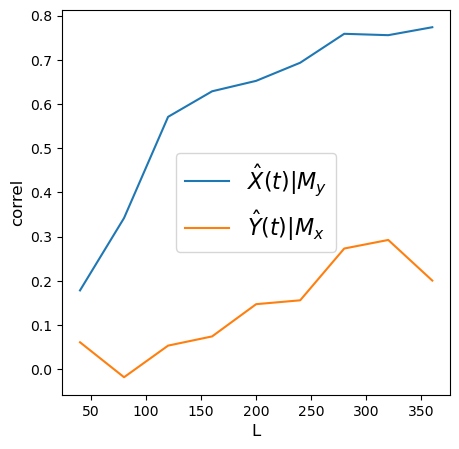

In [40]:
L_range = range(40, 400, 40) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})  

In [29]:
ccm_out['X:Y']

0    0.061997
1    0.077183
2    0.094718
3    0.101757
Name: X:Y, dtype: float64